This is an adaptation of a notebook by [Leon Eyrich Jessen](https://github.com/leonjessen/PepTools/commits?author=leonjessen)

### **Goal**
Training a neural network to predict if a peptide from the data set is strongly binding. This feature is categorical (NB = non-binding, WB = weakly binding, SB = strongly binding). The environment and dependencies are managed with the [nix package manager](https://nixos.org/).

### **Why Use Nix Flakes for Reproducibility?**  

Nix Flakes provide a structured, reproducible way to manage dependencies, ensuring that the development environment remains consistent across different machines.  

#### **Key Benefits:**  
- **Fully Reproducible Environments**  
  - All dependencies, including Python, R, TensorFlow, and PepTools, are explicitly defined.  
  - Version pinning ensures that package versions do not change unexpectedly.  

- **Isolation from System Packages**  
  - Dependencies are managed in a self-contained way, preventing conflicts with system-wide installations.  

- **Portability & Easy Setup**  
  - Running `nix develop` or `nix shell` instantly sets up the exact same environment across different systems. Once the shell is exited, the environment is no longer active, but its components remain cached until Nix's garbage collector (`nix-collect-garbage`) removes unused dependencies. This helps keep the user space clean while allowing efficient reuse of packages.

- **Custom Package Overlays**  
  - Since `PepTools` was not available in Nix repositories, it was manually packaged using an overlay with a specific commit hash, ensuring that the same version is always used.  

By using Nix Flakes, we eliminate dependency issues and create a reproducible workflow that guarantees consistency across different setups.


In [63]:
%%bash
curl -o pep_data.tsv "https://raw.githubusercontent.com/leonjessen/keras_tensorflow_demo/master/data/ran_peps_netMHCpan40_predicted_A0201_reduced_cleaned_balanced.tsv"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed


100  484k  100  484k    0     0  3875k      0 --:--:-- --:--:-- --:--:-- 3879k


The %load_ext rpy2.ipython command is used to enable the R magic commands in Jupyter notebooks. This allows running R code directly within the notebook, enabling seamless integration of Python and R workflows.

In [64]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [65]:
%%R
library(tidyverse)
library(PepTools)
library(ggseqlogo)

In [66]:
%%R
pep_data <- read_tsv("./pep_data.tsv")

Rows: 23760 Columns: 4
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (3): peptide, label_chr, data_type
dbl (1): label_num

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [67]:
%%R
pep_data_encoded = pep_data$peptide %>% pep_encode()
pep_data_encoded = as.data.frame(matrix(pep_data_encoded, nrow = dim(pep_data_encoded)[1]))
pep_data_encoded$label_chr = pep_data$label_chr
write_tsv(pep_data_encoded, file = "pep_data_encoded.tsv")


In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.utils import to_categorical

In [69]:
# Load the encoded data
data = pd.read_csv("pep_data_encoded.tsv", sep="\t")
data.head(10)

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V172,V173,V174,V175,V176,V177,V178,V179,V180,label_chr
0,0.04453,0.04453,0.07298,0.04104,0.29015,0.05588,0.04457,0.04713,0.06996,0.02429,...,0.09615,0.09615,0.07101,0.02425,0.06883,0.03529,0.03101,0.17673,0.26886,WB
1,0.04453,0.05221,0.29015,0.03383,0.04050,0.04453,0.04050,0.05525,0.06996,0.02429,...,0.09615,0.09237,0.06883,0.05497,0.04673,0.09615,0.04673,0.03131,0.26886,SB
2,0.06996,0.05221,0.10995,0.05685,0.04713,0.07298,0.04453,0.05685,0.07298,0.02195,...,0.26886,0.09237,0.04188,0.03101,0.17673,0.07101,0.09615,0.03101,0.07101,WB
3,0.10995,0.04453,0.04198,0.04453,0.07298,0.04270,0.06504,0.03383,0.06996,0.04014,...,0.04188,0.09615,0.02290,0.09615,0.07101,0.02697,0.05691,0.05497,0.26886,WB
4,0.04457,0.05588,0.03383,0.07298,0.06504,0.05221,0.04713,0.29015,0.06996,0.34496,...,0.03101,0.03529,0.05497,0.07101,0.05691,0.09237,0.17673,0.06883,0.26886,WB
5,0.04198,0.05588,0.04457,0.04453,0.29015,0.05685,0.07298,0.05221,0.05685,0.04580,...,0.02290,0.03529,0.03101,0.09615,0.06883,0.03101,0.07101,0.09237,0.03101,NB
6,0.03383,0.05221,0.04270,0.07827,0.04198,0.07298,0.04198,0.04713,0.29015,0.01903,...,0.05497,0.09237,0.02697,0.02429,0.02290,0.07101,0.02290,0.17673,0.06883,SB
7,0.05699,0.04713,0.04270,0.05685,0.04050,0.03383,0.10995,0.07827,0.29015,0.10708,...,0.03282,0.17673,0.02697,0.03101,0.04673,0.05497,0.04188,0.02429,0.06883,WB
8,0.03030,0.04453,0.04453,0.04713,0.03383,0.04198,0.04198,0.06504,0.05685,0.02273,...,0.03030,0.09615,0.09615,0.17673,0.05497,0.02290,0.02290,0.05691,0.03101,NB
9,0.04270,0.04713,0.03030,0.04453,0.29015,0.04713,0.04713,0.05525,0.04453,0.04494,...,0.02697,0.17673,0.03030,0.09615,0.06883,0.17673,0.17673,0.03131,0.09615,WB


The dataset pep_data_encoded.tsv is loaded into a Pandas dataframe and the input features (X) are extracted from the first 180 columns.

The target variable (label_chr) is one-hot encoded using pd.get_dummies(), transforming categorical labels into binary format.

In [70]:
X = data.iloc[:, :180].values
# Use get_dummies to one-hot encode the target variable "label_chr"
y_dummies = pd.get_dummies(data['label_chr'])
classes = y_dummies.columns.tolist()  # e.g., ['NB', 'SB', 'WB']
y = y_dummies.values

The dataset is split into training and testing sets using train_test_split() while maintaining class distribution through stratify.

In [71]:
# Split the data into training and test sets (80/20 split) using the original labels for stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=data['label_chr']
)

In [72]:
# Build the model (mirroring your R code architecture)
model = Sequential([
    Dense(180, activation='relu', input_shape=(180,)),
    Dropout(0.4),
    Dense(90, activation='relu'),
    Dropout(0.3),
    Dense(len(classes), activation='softmax')
])
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.RMSprop(),
              metrics=["accuracy"])
model.summary()

/nix/store/qm5v1ailrkpyyqhd92mi5zisb2gji0ip-python3-3.12.9-env/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_9 (Dense)                 │ (None, 180)            │        32,580 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 180)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 90)             │        16,290 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 90)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 3)              │           273 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 49,143 (191.96 KB)

 Trainable params: 49,143 (191.96 KB)

 Non-trainable params: 0 (0.00 B)

In [73]:
# Train the model with a 20% validation split
history = model.fit(X_train, y_train, epochs=150, batch_size=50, validation_split=0.2)


Epoch 1/150
305/305 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6313 - loss: 0.7613 - val_accuracy: 0.8498 - val_loss: 0.3494
Epoch 2/150
305/305 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8503 - loss: 0.3494 - val_accuracy: 0.9058 - val_loss: 0.2321
Epoch 3/150
305/305 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8810 - loss: 0.2878 - val_accuracy: 0.8359 - val_loss: 0.3597
Epoch 4/150
305/305 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8944 - loss: 0.2544 - val_accuracy: 0.9345 - val_loss: 0.1704
Epoch 5/150
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9089 - loss: 0.2233 - val_accuracy: 0.8943 - val_loss: 0.2307
Epoch 6/150
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9200 - loss: 0.1970 - val_accuracy: 0.9153 - val_loss: 0.1969
Epoch 7/150
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9273 - loss: 0.1798 - val_accuracy: 0.9479 - val_loss: 0.1352
Epoch 8/150
305/305 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9304 - loss: 0.1701 - val_accu

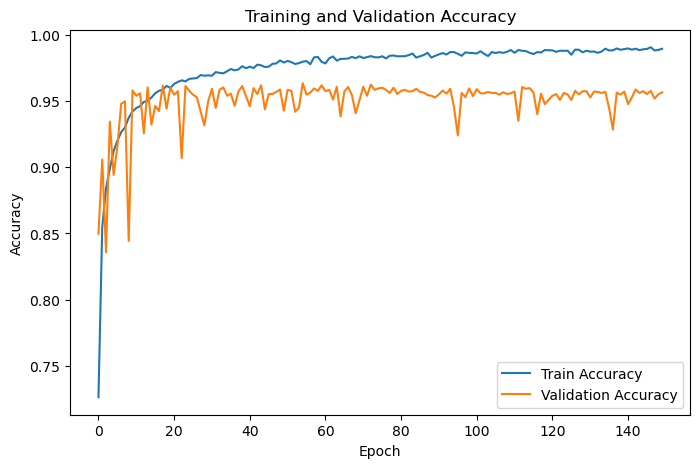

In [74]:
# Plot training and validation accuracy
plt.figure(figsize=(8, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

In [75]:
# Evaluate the model on the test set
perf = model.evaluate(X_test, y_test, verbose=0)
acc = round(perf[1] * 100, 3)
print("Test Accuracy: {}%".format(acc))

Test Accuracy: 95.939%


In [76]:
# Predict classes on the test set
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 644us/step


In [77]:
# Map predicted indices back to class names
y_pred_labels = [classes[i] for i in y_pred]
y_true_labels = [classes[i] for i in y_true]

In [78]:
results = pd.DataFrame({
    "y_true": y_true_labels,
    "y_pred": y_pred_labels
})
results['Correct'] = np.where(results['y_true'] == results['y_pred'], "yes", "no")
print(results.head())

  y_true y_pred Correct
0     NB     NB     yes
1     WB     WB     yes
2     WB     WB     yes
3     SB     SB     yes
4     SB     SB     yes


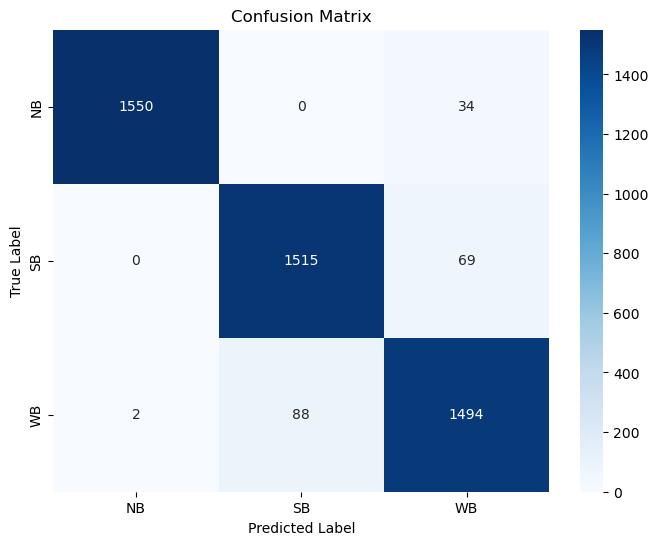

In [79]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

### Conclusion  

The neural network model demonstrates strong classification performance, achieving an overall accuracy of 95%.
